In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
%matplotlib inline

In [ ]:
# Exercise 1.a, b, c -> See notes

In [2]:
# Array of {x_n, t_n} with n = 1, ... , 10
# x_n: random from uniform distribution over [0, 1]
# t_n: sin(2*pi*x_n) + Gaussian Noise (sigma=0.25)
data = np.loadtxt('RegressionData.txt', skiprows=0, dtype=bytes, delimiter=' ').astype(float)

In [434]:
def plot(ax, data, **kwargs):
    mapping = np.array(data).T
    ax.plot(mapping[0], mapping[1], **kwargs)
    ax.set_title(kwargs['label'])

def scatter(ax, data, **kwargs):
    mapping = np.array(data).T
    ax.scatter(mapping[0], mapping[1], **kwargs)
    ax.set_title(kwargs['label'])

def quadratic_error(yT, y_x):
    return np.average(0.5 * (y_x - yT)**2)

def mlp(X, yTs, epsilon=1e-5, t_max=3000, eta=0.5):
    # Initial MLP params
    W = np.random.uniform(-0.5, 0.5, (2, 3))  # Weights between input and hidden layer (including bias)
    V = np.random.uniform(-0.5, 0.5, 4)  # Weights between hidden and output layer
    bias_output = np.random.uniform(-0.5, 0.5)
    
    # Stop iteration if error value has converged (epsilon=1e-5) or max iterartions(t_max = 3000) has been reached.
    errors = []
    epochs = 0
    f = np.tanh
    df = lambda x: 1 - np.tanh(x)**2
    while epochs < t_max and (len(errors) < 100 or np.abs(errors[-1] - errors[-2]) > epsilon):
        yXs = []
        gVs = np.zeros(V.shape)
        gWs = np.zeros(W.shape)
        for x, yT in zip(X, yTs):
            # Forward propagation (compute activation/transfer functions)
            yX = V.T.dot(np.array([1, *f(W.T.dot(np.array([1, x])))]))
            yXs.append(yX)
            # Backward propagation: (comupte gradient decent using local errors)
            gV = (yX - yT) * np.array([1, *f(W.T.dot(np.array([1, x])))])
            gW = np.zeros(W.shape)
            for i, j in list(itertools.product(range(gW.shape[1]), range(gW.shape[0]))):
                gW[j, i] = (yX - yT) * V[i] * df(W.T[i].dot([1, x])) * [1, x][j]
            # Calculate batch gradient using the local errors
            gVs += gV
            gWs += gW
        # Adopt gradient descent
        W -= eta * gWs / len(data)
        V -= eta * gVs / len(data)
        # Compute output error using the quadratic error cost function
        errors.append(quadratic_error(yTs, yXs))
        epochs += 1
    return epochs, errors, W, V, yXs

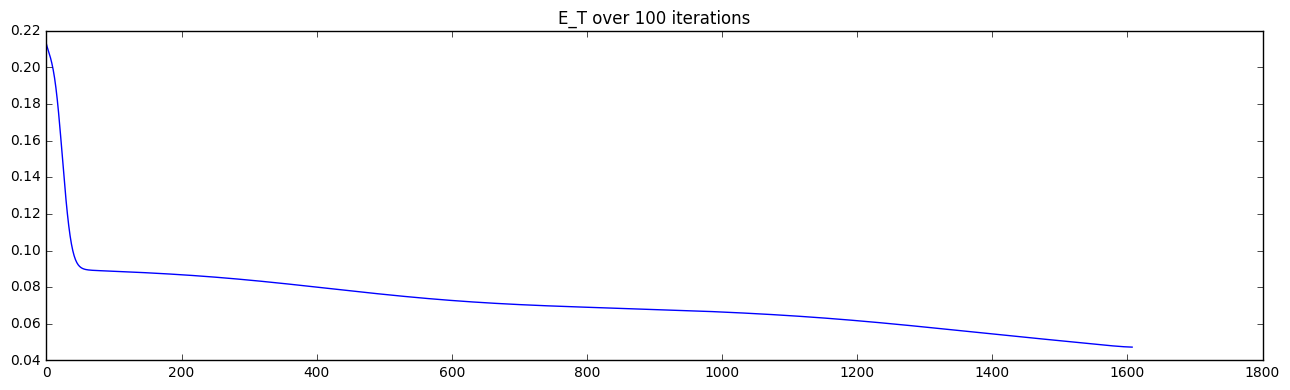

In [433]:
# Exercise 2.a: Plot E_T over iterations
np.random.seed(0)
epochs, errors, _, _, _ = mlp(*data.T)
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
plot(ax, list(enumerate(errors)), color='blue', label='E_T over {} iterations'.format(iterations))
fig.tight_layout()

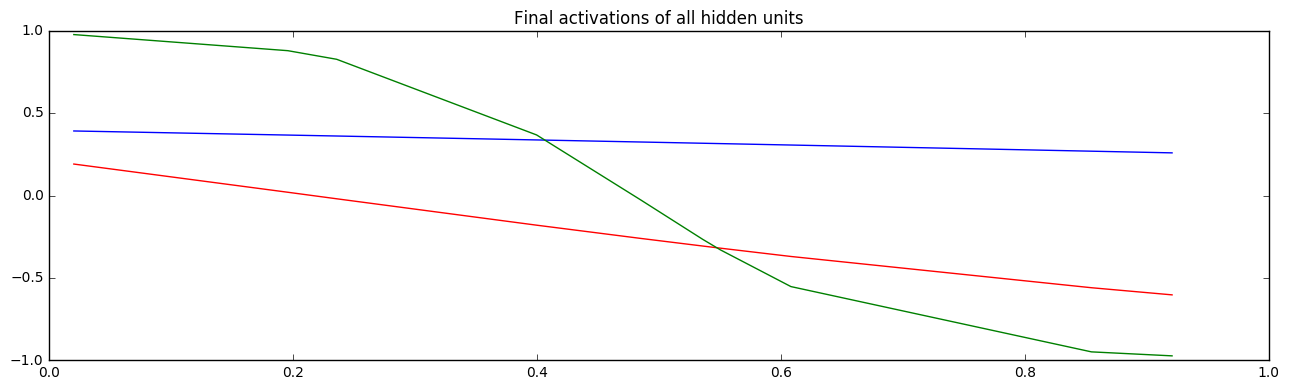

In [432]:
# Exercise 2.b: Plot activation functions of hidden units from the final resulting MLP over all inputs
np.random.seed(0)
_, _, W, V, _ = mlp(*data.T)
input_space = data[:, 0]

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
activators = [(x, np.tanh(W.T.dot(np.array([1, x])))) for x in input_space]
for i, color in enumerate(['red', 'blue', 'green']):
    activator = [(x, y[i]) for x, y in activators]
    activator.sort(key=lambda x: x[0])
    plot(ax, activator, color=color, label='Final activations of all hidden units')
fig.tight_layout()

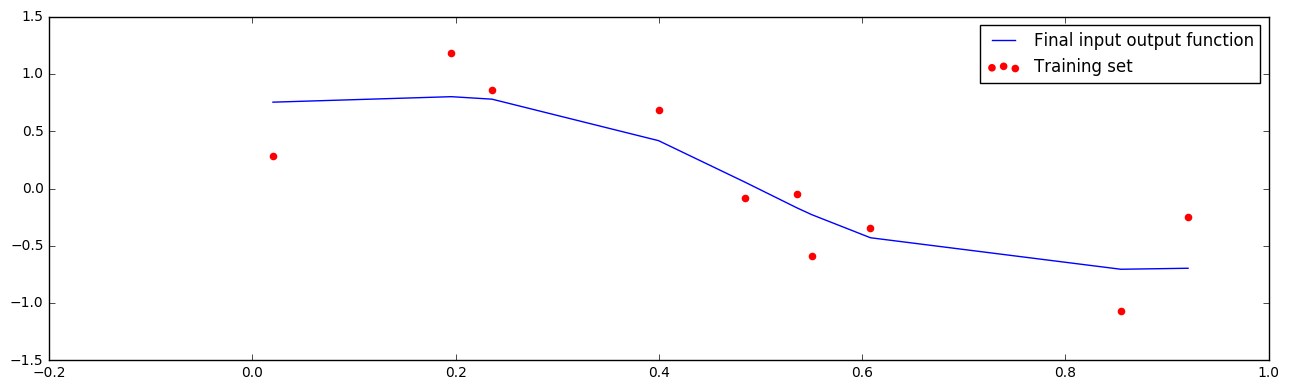

In [431]:
# Exercise 2.c: Plot MLPs input-output function vs the original function (training dataset) over the input space
np.random.seed(0)
training_set = sorted(data, key=lambda x: x[0])
input_space = data[:, 0]
_, _, _, _, yXs = mlp(*data.T)
input_output_function = sorted(list(zip(input_space, yXs)), key=lambda x: x[0])

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
scatter(ax, training_set, color='red', label='Training set')
plot(ax, input_output_function, color='blue', label='Final input output function')
ax.set_title('')
ax.legend()
fig.tight_layout()

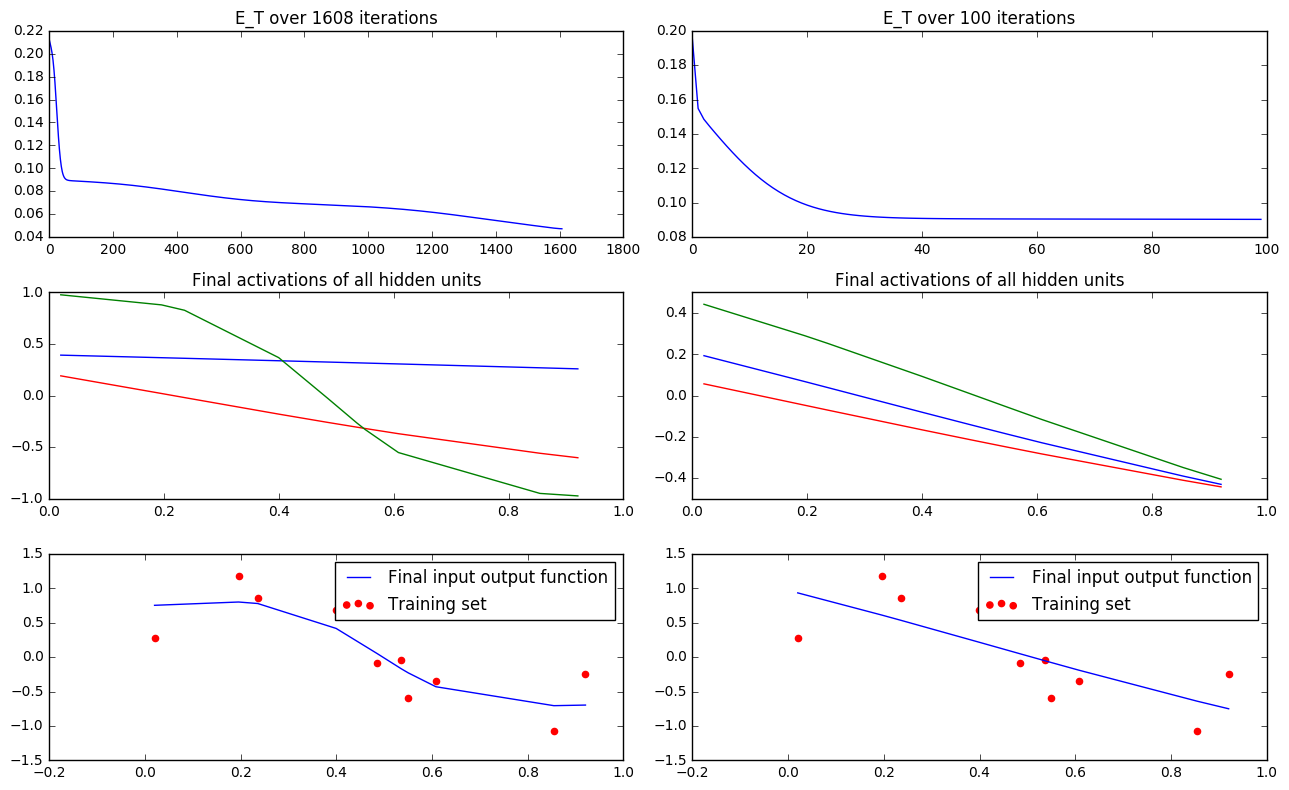

In [435]:
# Exercise 2.d: Plot a-c twice next to each other - Discuss: Is there a difference and why
np.random.seed(0)
fig, ax = plt.subplots(3, 2, figsize=(13, 8))
training_set = sorted(data, key=lambda x: x[0])
input_space = data[:, 0]

for i in (0, 1):
    epochs, errors, W, V, yXs = mlp(*data.T)
    # 1.a
    plot(ax[0, i], list(enumerate(errors)), color='blue', label='E_T over {} iterations'.format(epochs))
    # 1.b
    activators = [(x, np.tanh(W.T.dot(np.array([1, x])))) for x in input_space]
    for j, color in enumerate(['red', 'blue', 'green']):
        activator = [(x, y[j]) for x, y in activators]
        activator.sort(key=lambda x: x[0])
        plot(ax[1, i], activator, color=color, label='Final activations of all hidden units')
    # 1.c
    input_output_function = sorted(list(zip(input_space, yXs)), key=lambda x: x[0])
    scatter(ax[2, i], training_set, color='red', label='Training set')
    plot(ax[2, i], input_output_function, color='blue', label='Final input output function')
    ax[2, i].set_title('')
    ax[2, i].legend()

fig.tight_layout()

Discuss: Why are there differences?
===

Because the initial weights are generated randomly the gradient descent method most likely converges to another local minimum as before. That's why it finds a good solution but always depending on a different weighting matrix (See final activation functions).


Discuss: What is the motivation for a using a quadratic error function in this example?
===
The quadratic error cost functions is chosen because we know that the original function has a gaussian noise. This makes it also easier for the gradient descent method to compute dE/dY which equals yX-yT in this case.